In [3]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Embedding,Dense,Dropout,GRU, LSTM
from keras.models import Sequential
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
# Train-Test
from sklearn.model_selection import train_test_split
# Scaling data
from sklearn.preprocessing import StandardScaler
# Classification Report
from sklearn.metrics import classification_report

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
combined = pd.read_csv('../../tmp/sentence_based_data_300K.csv')
combined.head()

,text,target
0,"Thereby, the return oil is prevented from goin...",1
1,"', 'While the present inventors examined impro...",0
2,"For example, the inner core portion and the ou...",0
3,"In a case where the traffic amount is small, w...",2
4,"', 'In the twelfth aspect of the invention, ac...",0


Prepare input data

In [6]:
y = combined["target"]

In [7]:
y_cat = to_categorical(y)

In [8]:
texts = combined.text.values

In [9]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(texts)

In [10]:
max_len = 512

In [11]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=512)

In [12]:
data.shape

(300000, 512)

In [13]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,y_cat,test_size=0.2,random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=101)

In [14]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

240000
30000
30000


In [15]:
word_index = tokenizer.word_index

In [16]:
GLOVE_FILE = 'C:/Study/glove.6B.100d.txt'
f = open(GLOVE_FILE,'r',encoding="utf8")

In [17]:
embeddings_index = {}
import numpy as np
for line in f:
  values = line.split()
  word = values[0]
  embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [18]:
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Normal model

In [19]:
# from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix],trainable=False))

model.add(LSTM(units=128,dropout = 0.5,recurrent_dropout = 0.2))

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3,activation="softmax"))
# output model skeleton
opt = Adam(learning_rate = 0.005)
model.summary()
model.compile(optimizer= opt , loss ='categorical_crossentropy',metrics=['accuracy'])
plot_model(model, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         5669600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [20]:
model.fit(X_train, y_train, verbose=1, epochs=2)

Epoch 1/2
  21/7500 [..............................] - ETA: 2:34:08 - loss: 1.1110 - accuracy: 0.3333

KeyboardInterrupt: 

In [26]:
model.evaluate(X_test, y_test)

938/938 [==============================] - 68s 72ms/step - loss: 0.7037 - accuracy: 0.7117


[0.7037455439567566, 0.7116666436195374]

In [27]:
y_pred = model.predict(X_test)

938/938 [==============================] - 69s 73ms/step


In [28]:
print(y_pred.shape)
print(y_test.shape)

(30000, 3)
(30000, 3)


In [29]:
y_pred = (y_pred > 0.5)

In [30]:
y_pred[0]

array([False,  True, False])

In [31]:
print((classification_report(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.76      0.59      0.67      9993
           1       0.79      0.53      0.63     10051
           2       0.84      0.62      0.71      9956

   micro avg       0.80      0.58      0.67     30000
   macro avg       0.80      0.58      0.67     30000
weighted avg       0.80      0.58      0.67     30000
 samples avg       0.58      0.58      0.58     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sequential model LSTM

Without using glove embeddings

In [21]:
len(word_index)

56695

In [22]:
model1 = Sequential()
# model1.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix]))
model1.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
# model1.add(Embedding(max_words, 20))
model1.add(LSTM(64,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

model1.summary()
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
plot_model(model1, to_file='dl_model_lstm_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model1, to_file='dl_model_lstm_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5,712,035
Trainable params: 5,712,035
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 1585s 211ms/step - loss: 0.6098 - accuracy: 0.7525 - val_loss: 0.5537 - val_accuracy: 0.7785
Epoch 2/10
7500/7500 [==============================] - 1295s 173ms/step - loss: 0.5232 - accuracy: 0.7911 - val_loss: 0.5063 - val_accuracy: 0.7987
Epoch 3/10
7500/7500 [==============================] - 1269s 169ms/step - loss: 0.4928 - accuracy: 0.8049 - val_loss: 0.4833 - val_accuracy: 0.8088
Epoch 4/10
7500/7500 [==============================] - 1332s 178ms/step - loss: 0.4725 - accuracy: 0.8144 - val_loss: 0.4823 - val_accuracy: 0.8117
Epoch 5/10
7500/7500 [==============================] - 1369s 183ms/step - loss: 0.4580 - accuracy: 0.8217 - val_loss: 0.4717 - val_accuracy: 0.8161
Epoch 6/10
7500/7500 [==============================] - 1345s 179ms/step - loss: 0.4459 - accuracy: 0.8270 - val_loss: 0.4706 - val_accuracy: 0.8159
Epoch 7/10
7500/7500 [==============================] - 1319s 176ms/step - loss: 0.4381 - accuracy: 0.8310

In [24]:
a = len(history_1.history["loss"])

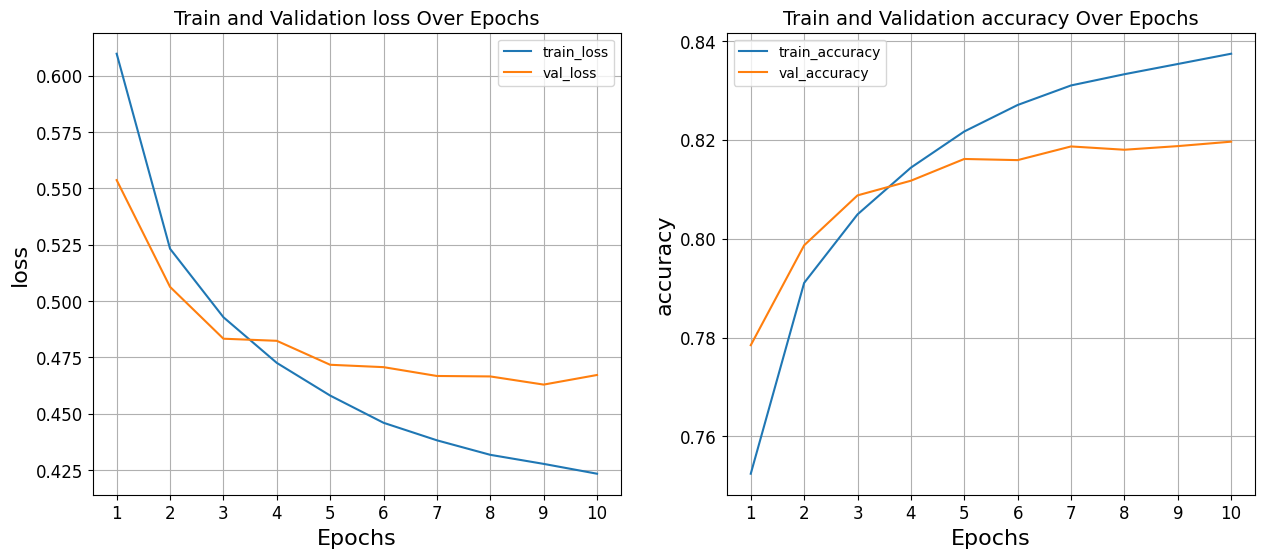

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_lstm_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_lstm_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [26]:
model1.evaluate(X_test, y_test)

938/938 [==============================] - 53s 57ms/step - loss: 0.4683 - accuracy: 0.8199


[0.4683351516723633, 0.8198666572570801]

In [27]:
y_pred_1 = model1.predict(X_test)

938/938 [==============================] - 55s 58ms/step


In [28]:
y_pred_1 = (y_pred_1 > 0.5)

In [29]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      9993
           1       0.82      0.78      0.80     10051
           2       0.87      0.86      0.86      9956

   micro avg       0.84      0.80      0.82     30000
   macro avg       0.84      0.80      0.82     30000
weighted avg       0.84      0.80      0.82     30000
 samples avg       0.80      0.80      0.80     30000



c:\Users\ranax\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the glove embeddings

In [30]:
len(word_index)

56695

In [31]:
model1 = Sequential()
model1.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
# model1.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
# model1.add(Embedding(max_words, 20))
model1.add(LSTM(64,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

model1.summary()
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#plot_model(model1, to_file='dl_model_lstm_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model1, to_file='dl_model_lstm_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          5669600   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5,712,035
Trainable params: 42,435
Non-trainable params: 5,669,600
_________________________________________________________________


In [32]:
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 1104s 147ms/step - loss: 0.7654 - accuracy: 0.6579 - val_loss: 0.6123 - val_accuracy: 0.7437
Epoch 2/10
7500/7500 [==============================] - 1117s 149ms/step - loss: 0.6179 - accuracy: 0.7398 - val_loss: 0.5480 - val_accuracy: 0.7783
Epoch 3/10
5486/7500 [====================>.........] - ETA: 4:52 - loss: 0.5878 - accuracy: 0.7551

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1),fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_lstm_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_lstm_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [ ]:
model1.evaluate(X_test, y_test)